# Inferring VC investment trends in 2020 using textual analysis of Twitter data

Venture capitalists (VCs) are known for utilizing a variety of resources, ranging from financial statements and research reports to aggregation platforms such as Crunchbase and Angellist, for uncovering market trends to optimize their investment strategy. An often overlooked resource for performing such market analyses is social media, which can serve as a goldmine of alternate data for providing additional leverage to VCs. One of such social media platforms that is currently popular with entrepreneurs and investors is Twitter, which can serve as an incredibly rich source of textual information indicating market activity that might be relevant for accumulating market intelligence. The goal of this project is to utilize unsupervised learning techniques for performing exploratory analysis on textual data from Twitter to uncover latent market trends, create market maps, and gather market intelligence. 

### Scraping:

Scraping tweets (max 300k) for "vc investment" query during the year 2020 using *snscrape*

In [ ]:
import snscrape.modules.twitter as sntwitter
import pandas as pd

# Creating a list to store the tweet data
tweets_list = []

# Using TwitterSearchScraper to scrape tweets and append to tweets_list
for i,tweet in enumerate(sntwitter.TwitterSearchScraper('vc investment since:2020-01-01 until:2020-12-31').get_items()):
    if i>300000: # Only scraping 300000 tweets
        break
    if i%1000 == 0:
        print(i)
    
    # Only appending tweets that are in English and have more than 10 likes
    if tweet.likeCount >= 10 and tweet.lang == "en":
        tweets_list.append(tweet.content)
    
print("Done scraping!")

Converting the list of tweets to a Pandas dataframe and saving to file for future analysis.

In [ ]:
# Creating a dataframe from tweets_list
tweets_df = pd.DataFrame(tweets_list, columns=["Text"])

# Saving dataframe to file for future analysis
tweets_df.to_pickle("venture_capital_investment.pkl")

In [2]:
# Loading dataframe from file if not scraping
import pandas as pd
tweets_df = pd.read_pickle("venture_capital_investment.pkl")

### Cleaning data:

Step 1: Remove all mentions, links and numbers (words following @, http, and numbers) (Note: not removing hastags as they contain relevant information for topic modeling)

In [4]:
for idx,tweet in enumerate(tweets_df["Text"]):
    tweets_df["Text"][idx] = ' '.join(i for i in tweet.split() if not (i.startswith('@') or i.startswith('http') or i.startswith('$') or i.isdigit()))

Step 2: Remove all stop words that don't contribute to topic modeling and tokenizing the tweets

In [5]:
import string
import nltk

nltk.download('stopwords')
nltk.download('punkt')
stop_words = nltk.corpus.stopwords.words('english')

# Adding punctuations to list of stopwords
stop_words += list(string.punctuation)

# Defining a function for converting to lowercase, tokenizing, and removing stopwords
def tokenize_and_removestopwords(text):
    tokens = nltk.word_tokenize(text)
    tokens = [token.lower() for token in tokens if token.lower() not in stop_words]
    return tokens
  
# Applying tokenizing to all tweets
for idx,tweet in enumerate(tweets_df["Text"]):
     tweets_df["Text"][idx] = tokenize_and_removestopwords(tweet)

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/Shobhit/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/Shobhit/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Step 3: Only select nouns

In [6]:
nltk.download('averaged_perceptron_tagger')

# Selecting only nouns from all tweets
for idx,tweet in enumerate(tweets_df["Text"]):
    updated_tweet = []
    tweet_pos = nltk.pos_tag(tweet)
    [updated_tweet.append(token[0]) for token in tweet_pos if (token[1] == "NN" or token[1] == "NNS")]
    tweets_df["Text"][idx] = updated_tweet

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/Shobhit/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


Step 4: Lemmatizing (reducing words to their base meaning)

In [7]:
nltk.download('wordnet')
lemmatizer = nltk.stem.WordNetLemmatizer()

def lemmatize_text(text):
    lemmatized = []
    for word in text:
        lemmatized.append(lemmatizer.lemmatize(word))
    return lemmatized

# Applying lemmatizing to all tweets
for idx,tweet in enumerate(tweets_df["Text"]):
     tweets_df["Text"][idx] = lemmatize_text(tweet)

[nltk_data] Downloading package wordnet to /Users/Shobhit/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Generating a frequency table that will be used to append the list of stopwords in a separate list called *irrelevant_words*

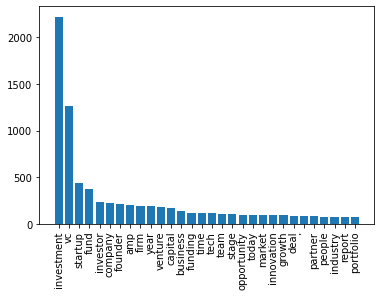

In [9]:
# Iterating through all tweets to construct a frequency table
words_list = [token for tweet in tweets_df["Text"] for token in tweet]

word_freq = nltk.probability.FreqDist(words_list)
most_common = word_freq.most_common(50)
most_common_terms = [term[0] for term in most_common]
most_common_terms_freq = [term[1] for term in most_common]

# Construct a bar plot to visualize frequencies of top 30 words
import matplotlib.pyplot as plt
plt.bar(x=list(range(1,31)), height=most_common_terms_freq[0:30], tick_label=most_common_terms[0:30])
plt.xticks(rotation = 90)
plt.show()

Removing additional stopwords (stored in *irrelevant words*) based on the top 30 frequent words in the frequency table

In [10]:
# Removing additional words from the tweets database
irrelevant_words = most_common_terms[0:30]
irrelevant_words.extend(["round", "money", "seed", "share", "post", "way", "entrepreneur", "bn", "part", "series", "return", "information", "woman", "impact", "world", "insight", "vcs", "member"])

# Applying filtering to all tweets
for idx,tweet in enumerate(tweets_df["Text"]):
    tweets_df["Text"][idx] = [token for token in tweet if token not in irrelevant_words]

Creating bag of words for LDA topic modeling

In [11]:
from gensim.corpora import Dictionary

# Creating a dictionary from tweets corpus(used to give a unique index to each word in the corpus)
text_dict = Dictionary(tweets_df["Text"])

# Creating bag of words (a frequency table for each tweet using the indices in the dictionary)
tweets_bow = [text_dict.doc2bow(tweet) for tweet in tweets_df["Text"]]

### Modeling:

Fitting LDA models to the tweets data with increasing number of topics and computing coherence scores to find the optimum parameters.

In [13]:
from gensim.models.ldamodel import LdaModel
from gensim.models.coherencemodel import CoherenceModel

coherence = []

for num_topics_ in range(3,12):
    tweets_lda_ = LdaModel(tweets_bow, num_topics = num_topics_, id2word = text_dict, random_state = 1, passes=50)
    cm = CoherenceModel(model=tweets_lda_, texts=tweets_df["Text"], dictionary=text_dict, coherence='c_v')                           
    coherence.append((num_topics_, cm.get_coherence()))

print("Done finding coherence scores!")

Done finding coherence scores!


Plotting coherence scores against number of topics.

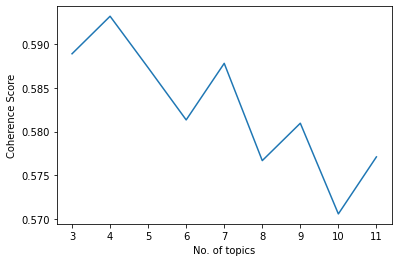

In [15]:
x = [i[0] for i in coherence]
y = [i[1] for i in coherence]
plt.plot(x, y)
plt.ylabel('Coherence Score')
plt.xlabel('No. of topics')
plt.show()

Fitting the model with optimum number of topics (topics leading to maximum coherence score).

In [16]:
tweets_lda = LdaModel(tweets_bow, num_topics = 4, id2word = text_dict, random_state = 1, passes=50)
print("Done fitting!")

Done fitting!


Visualizing the topic modeling output using *pyLDAvis*.

In [17]:
import pyLDAvis.gensim_models

pyLDAvis.enable_notebook()

vis = pyLDAvis.gensim_models.prepare(tweets_lda, tweets_bow, dictionary=tweets_lda.id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3     -0.043159  0.095660       1        1  26.815821
1     -0.066389  0.021722       2        1  25.118179
0      0.147328  0.006137       3        1  24.980342
2     -0.037779 -0.123519       4        1  23.085658, topic_info=                Term       Freq      Total Category  logprob  loglift
1702          search  43.000000  43.000000  Default  30.0000  30.0000
2428      traveltech  43.000000  43.000000  Default  29.0000  29.0000
2427  businessangels  40.000000  40.000000  Default  28.0000  28.0000
14          strategy  38.000000  38.000000  Default  27.0000  27.0000
188           thesis  34.000000  34.000000  Default  26.0000  26.0000
...              ...        ...        ...      ...      ...      ...
346           change   8.520346  19.559504   Topic4  -5.8754   0.6350
178             term  10.117676  35.752651   Topic4  -5.7036   0.2036
915         building   8.402840  19.558492   Topic4  -5.8893   0.6211
60         ecosystem   8.970052  35.614114   Topic4  -5.8239   0.0871
322         decision   8.324719  21.169766   Topic4  -5.8986   0.5326

[275 rows x 6 columns], token_table=      Topic      Freq         Term
term                              
1047      2  0.925232  accelerator
1264      4  0.973292      account
214       1  0.141653     activity
214       2  0.519394     activity
214       3  0.236088     activity
...     ...       ...          ...
2751      4  0.801800       yiming
165       2  0.189103            ”
165       3  0.642950            ”
165       4  0.113462            ”
2752      4  0.801800      🔥tiktok

[454 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 2, 1, 3])

Since the interacting pyLDAvis visualization doesn't work on Github, adding demo screenshots here for 2/4 topics.

<img src="figures/figure_1.png">
<img src="figures/figure_2.png">

### Initial impressions:

- 3/4 topics seem to have a distinct meaning (topic 1 - crypto and blockchain in india, topic 2 - covid19 and fintech, topic 3 - traveltech including space travel).
- Travel tech seems to be surprising, because not much travel has happened in 2020. This needs to be investigated further.